In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import copy
import time

from multi_rake import Rake
from sklearn import datasets, linear_model

# ls in data location
# import os
# print(os.listdir("./data"))

In [4]:
reviewsRawData = pd.read_csv("./data/Hotel_Reviews.csv", usecols=['Positive_Review', 'Negative_Review', 'Reviewer_Score'])

In [5]:
# to make sure there's no empty attribute
reviewsRawData.count()

Negative_Review    515738
Positive_Review    515738
Reviewer_Score     515738
dtype: int64

In [6]:
#since there's no empty attribute, we can seperate each column to convert reviews to numberic values
reviewsRawDataPos = reviewsRawData.Positive_Review[100000:515738, np.newaxis]
reviewsRawDataNeg = reviewsRawData.Negative_Review[100000:515738, np.newaxis]
reviewerScore = reviewsRawData.Reviewer_Score[100000:515738, np.newaxis]

In [7]:
rake = Rake()

reviewsNumData = copy.deepcopy(reviewsRawDataPos);

start_time = time.time()

for i in range(0, len(reviewsRawDataPos)):
    reviewsNumData[i][0] = 0
    # get important keywords with weight for each positive review
    posKeywords = rake.apply(reviewsRawDataPos[i][0])
    # each keyword's weight gets added up
    for eachTuple in posKeywords:
        reviewsNumData[i][0]= reviewsNumData[i][0] + eachTuple[1]/10
    
    # get important keywords with weight for each negative review
    negKeywords = rake.apply(reviewsRawDataNeg[i][0])
    # each keyword's weight gets subtracted
    for eachTuple in negKeywords:
        reviewsNumData[i][0]= reviewsNumData[i][0] - eachTuple[1]/10

    #print(reviewsNumData[i])

# con: due to size of the data, conversion takes time (~5mins)
print("Time taken for conversion: %s minutes " % ((time.time() - start_time)/60))

Time taken for conversion: 2.2656717896461487 minutes 


In [8]:
# This part was made with referencing Linear regression - OLS vs GD
# Split the data into training/testing sets
reviews_X_train = copy.deepcopy(reviewsNumData[:-84000]) # training set = all but last 84000 instances
reviews_X_test = copy.deepcopy(reviewsNumData[-84000:])  #test set = last 84000 instances
print(len(reviews_X_train))
print(len(reviews_X_test))
# Split the targets into training/testing sets
reviews_Y_train = copy.deepcopy(reviewerScore[:-84000])
reviews_Y_test = copy.deepcopy(reviewerScore[-84000:])
print(len(reviews_Y_train))
print(len(reviews_Y_test))

331738
84000
331738
84000


C:\Users\L\Anaconda3\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Coefficients: 
 0.18
Y-intercept: 
 8.31
Variance score: 0.15


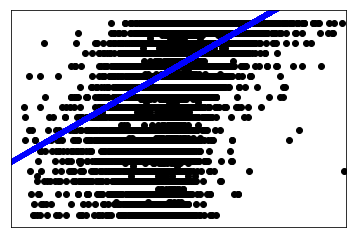

In [95]:
# This part was made with referencing Linear regression - OLS vs GD
# Create linear regression object

#regr = linear_model.LinearRegression() #run ordinary least squares

#Gradient Descent 
regr=linear_model.SGDRegressor(loss='squared_epsilon_insensitive', alpha=0.00001, max_iter=60, learning_rate='optimal'
                               , early_stopping = True, shuffle = True) #55.51
#regr=linear_model.SGDRegressor(loss='squared_epsilon_insensitive', alpha=0.00001, max_iter=45) #47.7
#regr=linear_model.SGDRegressor(loss='squared_epsilon_insensitive', alpha=0.00001, max_iter=65) #49.9
#regr=linear_model.SGDRegressor(loss='squared_epsilon_insensitive', alpha=0.00001, max_iter=55) #49.9
#regr=linear_model.SGDRegressor(loss='squared_epsilon_insensitive', alpha=0.00001, max_iter=50) #49
#regr=linear_model.SGDRegressor(loss='squared_epsilon_insensitive', alpha=0.000001, max_iter=50) #48.8
#regr=linear_model.SGDRegressor(loss='squared_epsilon_insensitive', alpha=0.000001, max_iter=30) #49.4
#learning_rate='optimal', early_stopping = True shuffle = True made result from the same setting inconsistent slightly but helped to get higher accuracy
#regr=linear_model.SGDRegressor(loss='huber', alpha=0.00001, max_iter=80) #48.9
#regr=linear_model.SGDRegressor(loss='squared_loss', alpha=0.0000000001, max_iter=80) #49.0
#regr=linear_model.SGDRegressor(loss='squared_loss', alpha=0.000000001, max_iter=150) #49.3
#regr=linear_model.SGDRegressor(loss='squared_loss', alpha=0.01, max_iter=60) #original

# Train the model using the training sets
regr.fit(reviews_X_train, reviews_Y_train) ##this is where "learning" happens!

# The coefficients
coef = round(copy.deepcopy(regr.coef_[0]),2)
intercept = round(copy.deepcopy(regr.intercept_[0]),2)
print('Coefficients: \n', coef)
print('Y-intercept: \n', intercept)
# The mean squared error
#print("Mean squared error: %.2f"
#     % np.mean((regr.predict(reviews_X_train) - reviews_Y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(reviews_X_test, reviews_Y_test))

# Plot outputs
plt.axis([-21, 21, 2, 10.5])
plt.scatter(reviews_X_test, reviews_Y_test,  color='black')
plt.plot(reviews_X_test, regr.predict(reviews_X_test), color='blue',
         linewidth=5)

plt.xticks(())
plt.yticks(())

plt.show()

In [96]:
from __future__ import division
from operator import truediv

dataForAccuracy = reviewsRawData.iloc[0:100000,]
#print(dataForAccuracy)

testPos = dataForAccuracy.Positive_Review[:, np.newaxis]
testNeg = dataForAccuracy.Negative_Review[:, np.newaxis]
actualScore = dataForAccuracy.Reviewer_Score[:, np.newaxis]
avgAccuracy = 0
for i in range(0, 100000):
    positiveResult = rake.apply(testPos[i][0])
    negativeResult = rake.apply(testNeg[i][0])

    positiveScore = 0
    negativeScore = 0

    if len(positiveResult) > 0:
        for i in range(0, len(positiveResult)) :
            positiveScore = positiveScore + positiveResult[i][1]
    #print("positiveScore : ", positiveScore)
    
    if len(negativeResult) > 0:
        for i in range(0, len(negativeResult)):
            negativeScore = negativeScore + negativeResult[i][1]
    #print("negativeScore : ", negativeScore)
    
    totalScore = positiveScore - negativeScore
    #print("totalScore : ", totalScore)
    
    expectedReviewScore = coef*totalScore + intercept
    #print("expectedReviewScore : ", expectedReviewScore)
    
    if expectedReviewScore > 10.0:
        expectedReviewScore = 10.0
    elif expectedReviewScore < 0.0:
        expectedReviewScore = 0.0
    else:
        expectedReviewScore = round(expectedReviewScore,2)

    #print("expectedReviewScore after conversion: ", expectedReviewScore)
    
    actualScoretemp = float(copy.deepcopy(actualScore[i]))
    #print("actualScoretemp : ", actualScoretemp)
    diff = abs(expectedReviewScore - actualScoretemp)
    #print("diff : ", diff)    
    
    #percTemp = 1.1
    if expectedReviewScore > actualScoretemp:
       decimal = diff/expectedReviewScore
    else:
        decimal = diff/actualScoretemp
    
    #print("percTemp : ", percTemp)
    eachAccuracy = (1-decimal)*100
    #print("currentScore : ", currentScore)
    
    avgAccuracy = avgAccuracy + eachAccuracy
    #print("totalReviewScore : ", totalReviewScore)
    
avgAccuracy = avgAccuracy/100000
print("avgAccuracy : ", avgAccuracy)




avgAccuracy :  55.51909888051452
